# DistilBERT Summary Comparison
Compare metrics from traditional and LLM runs.

In [1]:
import os
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

project_root = Path.cwd().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent
os.chdir(project_root)
print('Project root:', project_root)

def load_summary(path: Path, label: str) -> pd.DataFrame:
    data = json.loads(path.read_text(encoding='utf-8'))
    df = pd.DataFrame(data)
    metrics_expanded = pd.json_normalize(df['metrics']).add_prefix('metric_')
    df = pd.concat([df, metrics_expanded], axis=1)
    df['run_group'] = label
    return df

def pick_metric_from_row(row: pd.Series, candidate_keys):
    metrics_dict = row.get('metrics', {}) if isinstance(row.get('metrics', {}), dict) else {}
    for key in candidate_keys:
        metric_col = f'metric_{key}'
        if metric_col in row.index and pd.notna(row[metric_col]):
            return row[metric_col]
        value = metrics_dict.get(key)
        if value is not None:
            return value
    return float('nan')

metric_aliases = {
    'macro_f1': ['macro_f1', 'test_macro_f1_from_regression', 'eval_macro_f1_from_regression'],
    'roc_auc': ['roc_auc', 'test_roc_auc', 'eval_roc_auc'],
    'dp_diff': ['dp_diff', 'demographic_parity_diff', 'dp_gap'],
    'test_loss': ['test_loss'],
    'test_mae': ['test_mae'],
    'test_rmse': ['test_rmse'],
    'test_pearson': ['test_pearson'],
    'test_spearman': ['test_spearman'],
    'eval_loss': ['eval_loss'],
    'eval_mae': ['eval_mae'],
    'eval_rmse': ['eval_rmse'],
    'eval_pearson': ['eval_pearson'],
    'eval_spearman': ['eval_spearman']
}

trad_df = load_summary(project_root / 'outputs/distilbert_imputed_runs/summary.json', 'traditional')
llm_df = load_summary(project_root / 'outputs/distilbert_imputed_llm_runs_third/summary.json', 'llm')
df = pd.concat([trad_df, llm_df], ignore_index=True, sort=False)
for column, keys in metric_aliases.items():
    df[column] = df.apply(lambda row, k=keys: pick_metric_from_row(row, k), axis=1)
display_columns = ['dataset', 'run_group'] + list(metric_aliases.keys())
df[display_columns].head()

Project root: /m/home/home3/33/lil14/data/Documents/Project/LLMImputation_ResearchMethodology


,dataset,run_group,macro_f1,roc_auc,dp_diff,test_loss,test_mae,test_rmse,test_pearson,test_spearman,eval_loss,eval_mae,eval_rmse,eval_pearson,eval_spearman
0,train_text_imputed_mar_knn_05.parquet,traditional,0.407186,NaN,NaN,1.059670,0.748568,1.029403,0.729761,0.739631,0.689368,0.577425,0.830282,0.830382,0.805169
1,train_text_imputed_mar_knn_15.parquet,traditional,0.412088,NaN,NaN,1.065181,0.752600,1.032076,0.726207,0.737198,0.595803,0.530840,0.771883,0.856055,0.821198
2,train_text_imputed_mar_knn_30.parquet,traditional,0.390948,NaN,NaN,1.186412,0.802783,1.089225,0.691095,0.710103,0.474792,0.462645,0.689052,0.887729,0.848573
3,train_text_imputed_mar_simple_most_frequent_05...,traditional,0.403625,NaN,NaN,1.041724,0.744919,1.020649,0.728281,0.737516,0.812460,0.654732,0.901365,0.790778,0.774210
4,train_text_imputed_mar_simple_most_frequent_15...,traditional,0.407152,NaN,NaN,1.084767,0.761677,1.041521,0.719984,0.731841,0.937823,0.714907,0.968412,0.754905,0.741364


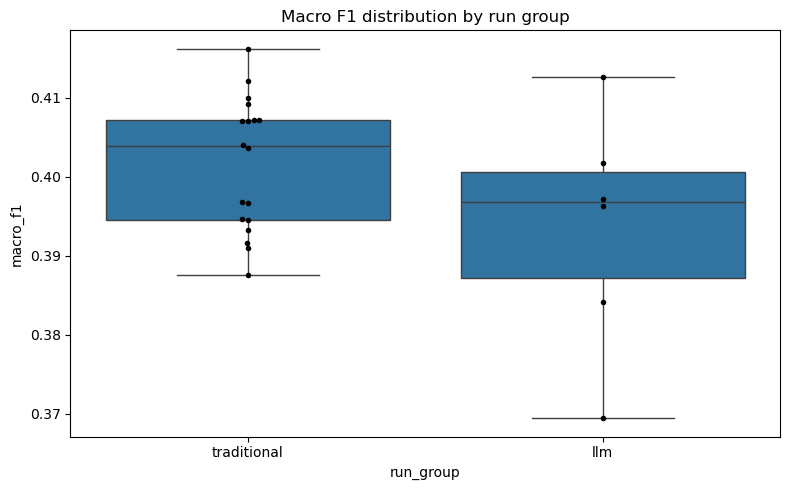

Skipping roc_auc plot: no data found in summaries.
Skipping dp_diff plot: no data found in summaries.


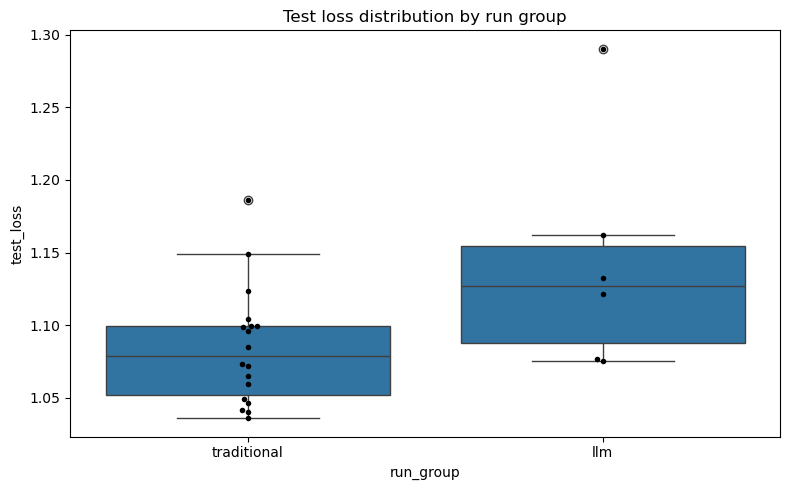

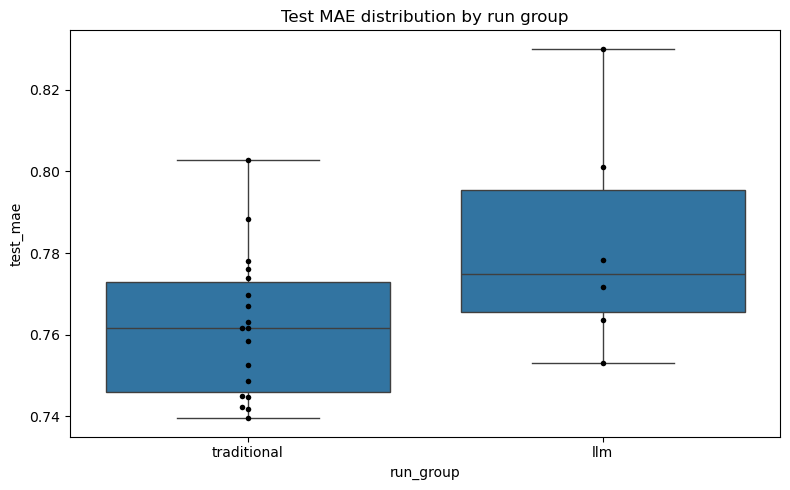

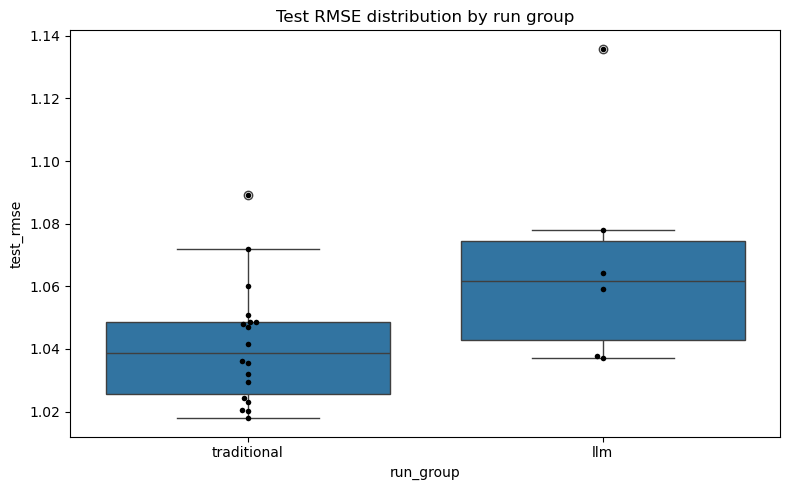

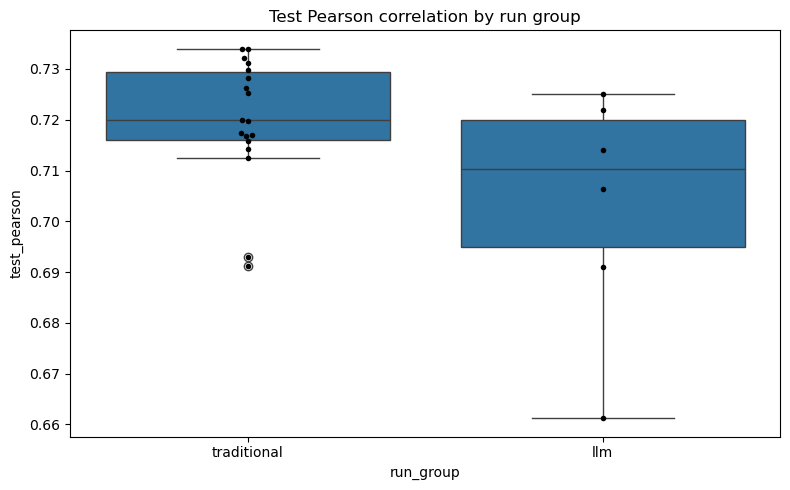

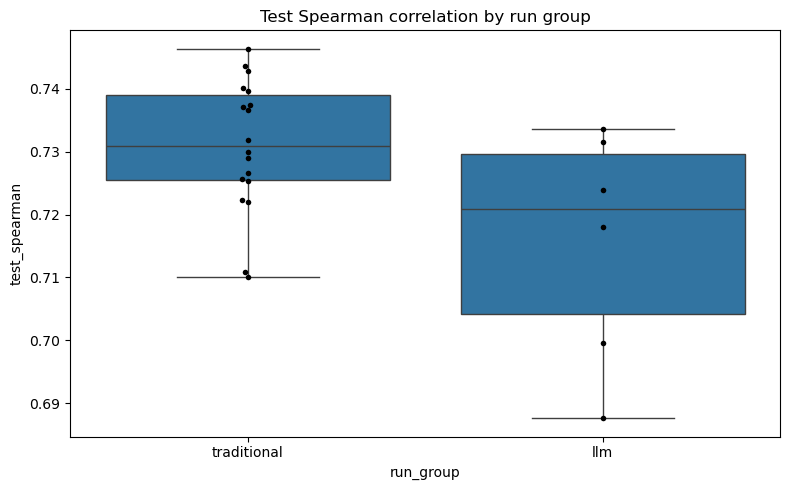

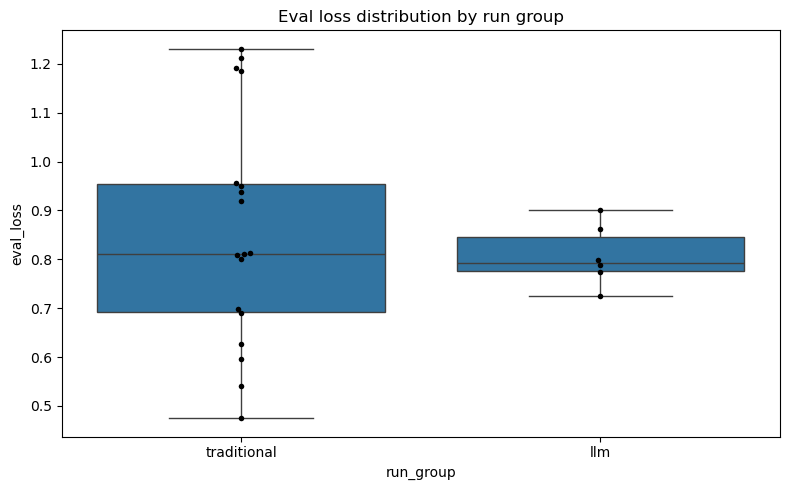

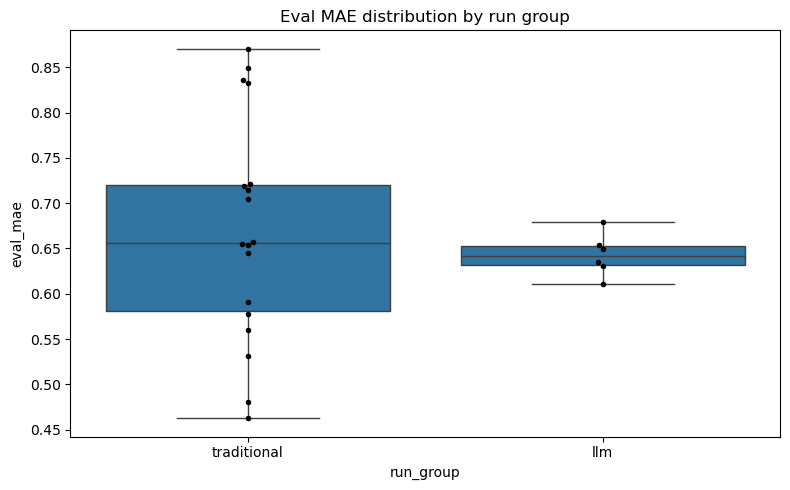

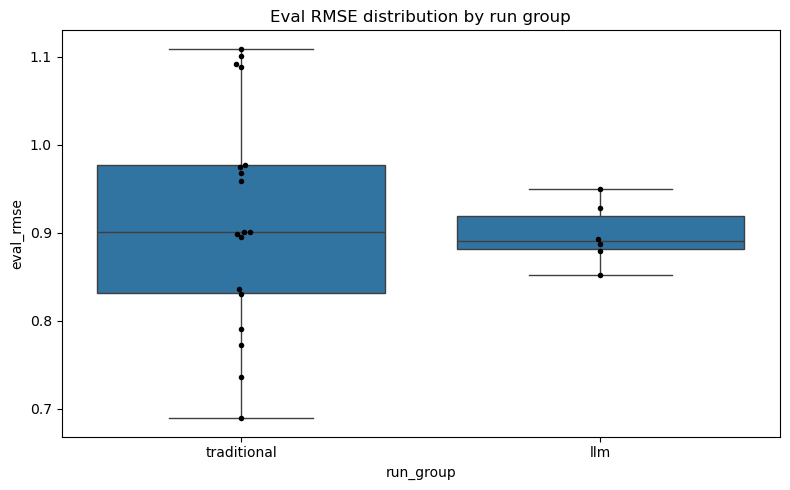

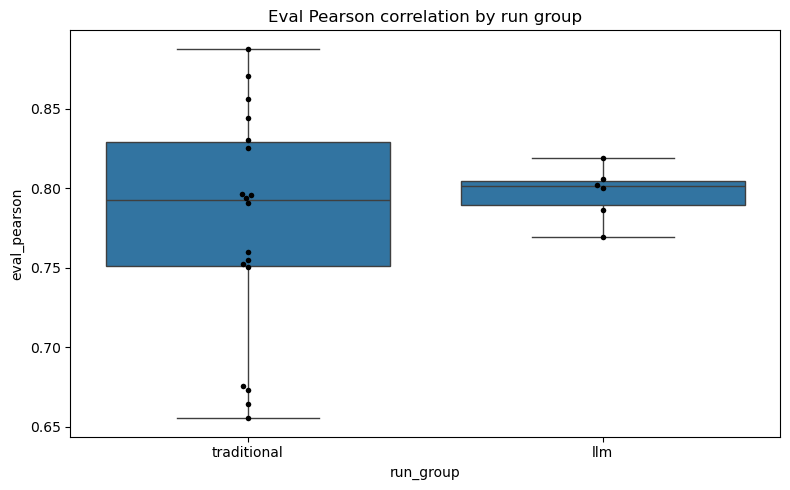

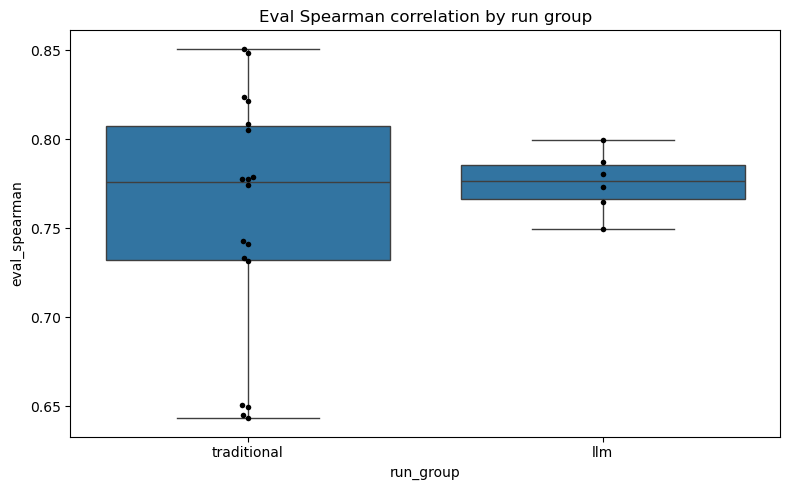

In [2]:
plot_columns = {
    'macro_f1': 'Macro F1 distribution by run group',
    'roc_auc': 'ROC-AUC distribution by run group',
    'dp_diff': 'DP difference distribution by run group',
    'test_loss': 'Test loss distribution by run group',
    'test_mae': 'Test MAE distribution by run group',
    'test_rmse': 'Test RMSE distribution by run group',
    'test_pearson': 'Test Pearson correlation by run group',
    'test_spearman': 'Test Spearman correlation by run group',
    'eval_loss': 'Eval loss distribution by run group',
    'eval_mae': 'Eval MAE distribution by run group',
    'eval_rmse': 'Eval RMSE distribution by run group',
    'eval_pearson': 'Eval Pearson correlation by run group',
    'eval_spearman': 'Eval Spearman correlation by run group'
}

for column, title in plot_columns.items():
    if column in df.columns and df[column].notna().any():
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x='run_group', y=column)
        sns.swarmplot(data=df, x='run_group', y=column, color='black', size=4)
        if column == 'dp_diff':
            plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print(f'Skipping {column} plot: no data found in summaries.')

In [3]:
summary_metrics = [col for col in metric_aliases if col in df.columns and df[col].notna().any()]
summary = (df.groupby('run_group')[summary_metrics]
           .agg(['mean', 'median', 'std']))
summary

macro_f1                     test_loss                      \
                 mean    median       std      mean    median       std   
run_group                                                                 
llm          0.393571  0.396779  0.014974  1.143087  1.127162  0.079442   
traditional  0.401629  0.403837  0.008427  1.084821  1.079038  0.040122   

             test_mae                     test_rmse  ...  eval_mae eval_rmse  \
                 mean    median       std      mean  ...       std      mean   
run_group                                            ...                       
llm          0.782958  0.774940  0.028188  1.068632  ...  0.023382  0.898335   
traditional  0.761972  0.761669  0.017518  1.041382  ...  0.123921  0.917788   

                                eval_pearson                      \
               median       std         mean    median       std   
run_group                                                          
llm          0.890558  0.035148     0.797185  0.801220  0.017234   
traditional  0.900873  0.128134     0.776543  0.792426  0.072248   

            eval_spearman                      
                     mean    median       std  
run_group                                      
llm              0.775654  0.776687  0.017654  
traditional      0.755726  0.775872  0.069565  

[2 rows x 33 columns]